# 코로나
* https://www.egbiz.or.kr/prjCategory/a/m/selectPrjView.do?prjDegreeId=PD000000019032
* https://zzsza.github.io/data/2019/02/06/prophet/

* 지역별로 나눠서, 이상치 제거해서 시계열 돌려보기

In [ ]:
import pandas as pd
import numpy as np
from fbprophet import Prophet

In [ ]:
data = pd.read_csv('/content/1-1_전체_데이터_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4194 entries, 0 to 4193
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   기준일(발병일, 확진일 선택)  4194 non-null   object
 1   지역 + 시            4194 non-null   object
 2   무증상/조사중           4194 non-null   object
 3   필터(무증상,조사중 제외)    4194 non-null   object
 4   무증상/조사중 기준일       4194 non-null   object
 5   지역                4194 non-null   object
 6   지역 (group)        4194 non-null   object
 7   확진일자              4194 non-null   object
 8   레코드 수             4194 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 295.0+ KB


In [ ]:
data.head() # 원 데이터

,"기준일(발병일, 확진일 선택)",지역 + 시,무증상/조사중,"필터(무증상,조사중 제외)",무증상/조사중 기준일,지역,지역 (group),확진일자,레코드 수
0,2020. 1. 26.,고양시,,참,2020. 1. 26.,고양일산서,고양,2020-01-26,1
1,2020. 1. 27.,평택시,,참,2020. 1. 27.,평택,평택,2020-01-27,1
2,2020. 2. 1.,부천시,,참,2020. 2. 1.,부천,부천,2020-02-01,1
3,2020. 2. 2.,부천시,,참,2020. 2. 2.,부천,부천,2020-02-02,1
4,2020. 2. 2.,수원시,,참,2020. 2. 2.,수원장안,수원,2020-02-02,1


In [ ]:
data.iloc[:,7] = pd.to_datetime(data.iloc[:,7])
a = data.iloc[:,[1,7]]
a.columns = ['지역','확진일']
a.head()

,지역,확진일
0,고양시,2020-01-26
1,평택시,2020-01-27
2,부천시,2020-02-01
3,부천시,2020-02-02
4,수원시,2020-02-02


In [ ]:
b = a['지역'].unique()
b

array(['고양시', '평택시', '부천시', '수원시', '구리시', '시흥시', '김포시', '이천시', '포천시',
       '안양시', '용인시', '파주시', '남양주시', '성남시', '과천시', '광명시', '화성시', '오산시',
       '군포시', '의왕시', '안산시', '광주시', '안성시', '의정부시', '하남시', '동두천시', '양주시',
       '가평군', '양평군', '여주시', '연천군'], dtype=object)

In [ ]:
c = pd.DataFrame(pd.date_range('2020-01-26', periods=240))
c.columns = ['ds']
c['y'] = 0
c

,ds,y
0,2020-01-26,0
1,2020-01-27,0
2,2020-01-28,0
3,2020-01-29,0
4,2020-01-30,0
...,...,...
235,2020-09-17,0
236,2020-09-18,0
237,2020-09-19,0
238,2020-09-20,0


In [ ]:
for i in range(len(b)):
    globals()['a_%s' % b[i]] = pd.DataFrame(pd.date_range('2020-01-26', periods=240))
    globals()['a_%s' % b[i]] = pd.DataFrame(a[a['지역'] == b[i]]['확진일'].value_counts()).sort_index()
    globals()['a_%s' % b[i]].reset_index(inplace = True)
    globals()['a_%s' % b[i]].columns = ['ds','y']
    globals()['b_%s' % b[i]] = pd.merge(c, globals()['a_%s' % b[i]], on='ds', how = 'left')
    globals()['b_%s' % b[i]]['y'] = np.where(pd.notnull(globals()['b_%s' % b[i]]['y_y']) == True, globals()['b_%s' % b[i]]['y_y'], globals()['b_%s' % b[i]]['y_x'])
    del globals()['b_%s' % b[i]]['y_x'], globals()['b_%s' % b[i]]['y_y']
    globals()['b_%s' % b[i]]['floor'] = 0
    globals()['b_%s' % b[i]]['cap'] = 100

In [ ]:
b_고양시 # 시게열 예측에 활용하기 위한 데이터 프레임

,ds,y,floor,cap
0,2020-01-26,1.0,0,100
1,2020-01-27,0.0,0,100
2,2020-01-28,0.0,0,100
3,2020-01-29,0.0,0,100
4,2020-01-30,0.0,0,100
...,...,...,...,...
235,2020-09-17,4.0,0,100
236,2020-09-18,12.0,0,100
237,2020-09-19,5.0,0,100
238,2020-09-20,2.0,0,100


In [ ]:
# 시계열 모델 구현
for i in range(len(b)): 
    globals()['m1_%s' % b[i]] = Prophet(growth='logistic', changepoints=['2020-03-28', '2020-05-13', '2020-07-01', '2020-08-23', '2020-09-06', '2020-09-20'])
    globals()['m1_%s' % b[i]].fit(globals()['b_%s' % b[i]])
    globals()['future1_%s' % b[i]] = globals()['m1_%s' % b[i]].make_future_dataframe(periods = 30)
    globals()['future1_%s' % b[i]]['floor'] = 0
    globals()['future1_%s' % b[i]]['cap'] = 100
    globals()['forecast1_%s' % b[i]] = globals()['m1_%s' % b[i]].predict(globals()['future1_%s' % b[i]])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

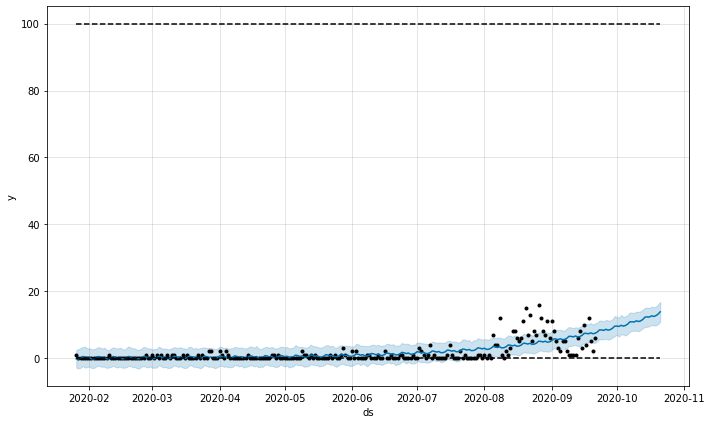

In [ ]:
# 시계열 예측 그래프
fig1 = m1_고양시.plot(forecast1_고양시)

In [ ]:
forecast1_고양시.iloc[248:253,[0,17]] # 시계열 예측 데이터 프레임

,ds,yhat
248,2020-09-30,9.527617
249,2020-10-01,9.551300
250,2020-10-02,9.459476
251,2020-10-03,9.782426
252,2020-10-04,9.555510


In [ ]:
forecast1_고양시.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          270 non-null    datetime64[ns]
 1   trend                       270 non-null    float64       
 2   cap                         270 non-null    int64         
 3   floor                       270 non-null    int64         
 4   yhat_lower                  270 non-null    float64       
 5   yhat_upper                  270 non-null    float64       
 6   trend_lower                 270 non-null    float64       
 7   trend_upper                 270 non-null    float64       
 8   additive_terms              270 non-null    float64       
 9   additive_terms_lower        270 non-null    float64       
 10  additive_terms_upper        270 non-null    float64       
 11  weekly                      270 non-null    float64       

In [ ]:
d = pd.DataFrame(b)
d.columns = ['지역']
e = []
f = []
g = []
h = []
j = []
for i in range(len(b)):
  e.append(globals()['forecast1_%s' % b[i]].iloc[248,17])
  f.append(globals()['forecast1_%s' % b[i]].iloc[249,17])
  g.append(globals()['forecast1_%s' % b[i]].iloc[250,17])
  h.append(globals()['forecast1_%s' % b[i]].iloc[251,17])
  j.append(globals()['forecast1_%s' % b[i]].iloc[252,17])
d['9월 30일 예측'] = e
d['10월 1일 예측'] = f
d['10월 2일 예측'] = g
d['10월 3일 예측'] = h
d['10월 4일 예측'] = j
d

,지역,9월 30일 예측,10월 1일 예측,10월 2일 예측,10월 3일 예측,10월 4일 예측
0,고양시,9.527617,9.551300,9.459476,9.782426,9.555510
1,평택시,1.162909,1.339653,1.958205,1.810958,0.901536
2,부천시,3.129594,2.754975,2.555758,2.531941,2.233509
3,수원시,1.323410,1.156042,1.044469,1.156081,0.658482
4,구리시,0.008220,-0.134213,-0.020301,-0.077285,0.185843
5,시흥시,1.012648,1.185181,0.986503,0.987714,0.881433
6,김포시,0.142650,-0.001262,0.027520,0.171431,-0.167282
7,이천시,-0.097564,0.312942,0.137012,-0.009596,-0.151508
8,포천시,0.317668,-0.087185,0.086326,-0.231773,0.056697
9,안양시,0.006727,0.087445,0.141230,-0.101258,0.127682


In [ ]:
# 일별 경기도 전체 확진자 수 예측 (9월 30일 - 10월 4일)
for i in range(1,6):
  print(sum(d.iloc[:,i]))

19.67262318255671
20.144307761569422
21.72124181990187
19.958394523506225
15.584081610002233
